In [ ]:
!pip install vit_keras

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.2 MB/s eta 0:00:00


In [ ]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
from vit_keras import vit

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score


import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model


#import shap
#shap.initjs()

In [ ]:
IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 19
AUTO = tf.data.AUTOTUNE

In [ ]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path, images


train_images = create_images_list('/content/drive/MyDrive/Smoking Image Detection with CNN/Image Dataset/Training')
valid_imaged = create_images_list('/content/drive/MyDrive/Smoking Image Detection with CNN/Image Dataset/Validation')
test_images = create_images_list('/content/drive/MyDrive/Smoking Image Detection with CNN/Image Dataset/Testing')

# look-up table
classes = {0:'not_smoking', 1 : 'smoking'}

In [ ]:
train_data = pd.DataFrame({'img': train_images[0], 'label': np.NaN, 'image_name': train_images[1]})
valid_data = pd.DataFrame({'img': valid_imaged[0], 'label': np.NaN, 'image_name': valid_imaged[1]})
test_data = pd.DataFrame({'img': test_images[0], 'label': np.NaN, 'image_name': test_images[1]})


def create_class(X):
    reg = re.split("_", X)
    if reg[0] == 'notsmoking':
        return 0
    elif reg[0] == 'smoking':
        return 1
    else:
        print('wrong class ...')

train_data['label'] = train_data['image_name'].apply(create_class)
valid_data['label'] = valid_data['image_name'].apply(create_class)
test_data['label'] = test_data['image_name'].apply(create_class)


In [ ]:
train_data = shuffle(train_data, random_state = SEED).reset_index(drop = True)
valid_data = shuffle(valid_data, random_state = SEED).reset_index(drop = True)
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)


print("train images -> ", train_data.shape[0])
print("valid images -> ", valid_data.shape[0])
print("test images -> ", test_data.shape[0])

train_data.head()

train images ->  716
valid images ->  180
test images ->  224


,img,label,image_name
0,/content/drive/MyDrive/Smoking Image Detection...,1,smoking_0141.jpg
1,/content/drive/MyDrive/Smoking Image Detection...,1,smoking_0227.jpg
2,/content/drive/MyDrive/Smoking Image Detection...,1,smoking_0410.jpg
3,/content/drive/MyDrive/Smoking Image Detection...,0,notsmoking_0407.jpg
4,/content/drive/MyDrive/Smoking Image Detection...,0,notsmoking_0093.jpg


In [ ]:
test_data.head()

,img,label,image_name
0,/content/drive/MyDrive/Smoking Image Detection...,0,notsmoking_0500.jpg
1,/content/drive/MyDrive/Smoking Image Detection...,1,smoking_0254.jpg
2,/content/drive/MyDrive/Smoking Image Detection...,1,smoking_0277.jpg
3,/content/drive/MyDrive/Smoking Image Detection...,0,notsmoking_0549.jpg
4,/content/drive/MyDrive/Smoking Image Detection...,1,smoking_0407.jpg


In [ ]:
test_data['label']

0      0
1      1
2      1
3      0
4      1
      ..
219    0
220    1
221    0
222    0
223    0
Name: label, Length: 224, dtype: int64

In [ ]:
y_test = test_data['label']
y_test

0      0
1      1
2      1
3      0
4      1
      ..
219    0
220    1
221    0
222    0
223    0
Name: label, Length: 224, dtype: int64

In [ ]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 5, seed = SEED)

    return img, label

In [ ]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


# Training dataset without shuffling and data augmantation operations for the classification stage
train_loader_feature = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset_feature = (train_loader_feature
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['img'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

In [ ]:
# Creatin mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

In [ ]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 2)

    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(64, activation = 'gelu', name = 'the_feature_layer')(X)
    X = Dense(16, activation = 'gelu')(X)
    out = Dense(2, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc'] )

347502902/347502902 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 64)                49216     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                            

In [ ]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, epochs = 20, batch_size = BATCH_SIZE, validation_data = valid_dataset)

Epoch 1/20
23/23 [==============================] - 147s 3s/step - loss: 0.5578 - acc: 0.7304 - val_loss: 0.3773 - val_acc: 0.8222
Epoch 2/20
23/23 [==============================] - 40s 2s/step - loss: 0.3516 - acc: 0.8492 - val_loss: 0.2293 - val_acc: 0.9222
Epoch 3/20
23/23 [==============================] - 36s 1s/step - loss: 0.1837 - acc: 0.9288 - val_loss: 0.1662 - val_acc: 0.9389
Epoch 4/20
23/23 [==============================] - 36s 2s/step - loss: 0.1058 - acc: 0.9679 - val_loss: 0.1826 - val_acc: 0.9278
Epoch 5/20
23/23 [==============================] - 39s 2s/step - loss: 0.0459 - acc: 0.9916 - val_loss: 0.1806 - val_acc: 0.9389
Epoch 6/20
23/23 [==============================] - 39s 2s/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.3074 - val_acc: 0.9222
Epoch 7/20
23/23 [==============================] - 36s 2s/step - loss: 0.0199 - acc: 0.9944 - val_loss: 0.2296 - val_acc: 0.9278
Epoch 8/20
23/23 [==============================] - 37s 2s/step - loss: 0.0265 - acc: 0.9

In [ ]:
# Validation and Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    val_eval_vit = model.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
    print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
6/6 [==============================] - 3s 448ms/step - loss: 0.2924 - acc: 0.9167
Validation Loss: 0.292
Validation Accuracy: 91.667 %
----------------------------------------------------------------------------------------------------
7/7 [==============================] - 47s 7s/step - loss: 0.2577 - acc: 0.9062
Test Loss: 0.258
Test Accuracy: 90.625 %


In [ ]:
# Making Prediction

y_pred = np.argmax(model.predict(test_dataset), axis=-1)
y_pred

7/7 [==============================] - 8s 470ms/step


array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0])

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

print("Accuracy Score   : {:.2f} %".format(accuracy_score(y_test, y_pred) * 100))
print("Precision Score : {:.2f} %".format(precision_score(y_test, y_pred) * 100))
print("Recall Score    : {:.2f} %".format(recall_score(y_test, y_pred) * 100))
print("F1 Score    : {:.2f} %".format(f1_score(y_test, y_pred) * 100))
print("AUC Score    : {:.2f} %".format(roc_auc_score(y_test, y_pred) * 100))

Accuracy Score   : 90.62 %
Precision Score : 97.89 %
Recall Score    : 83.04 %
F1 Score    : 89.86 %
AUC Score    : 90.62 %


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test,y_pred)
cm

array([[110,   2],
       [ 19,  93]])

<Axes: >

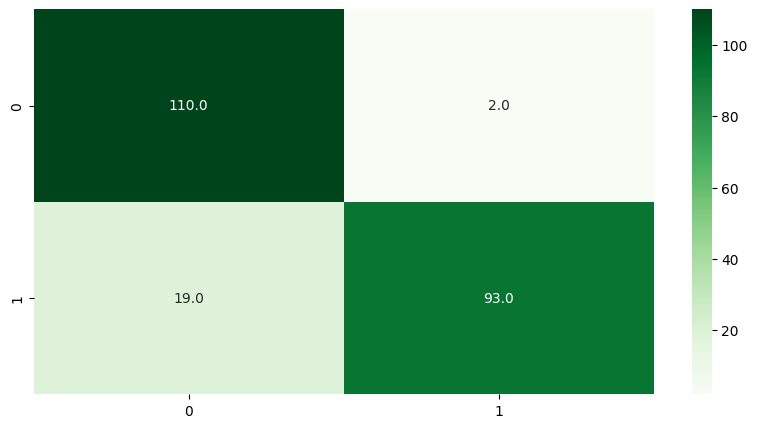

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))

sns.heatmap(cm,annot=True, fmt=".1f", cmap="Greens")